### Author : Sayali Kudale

### Implementation of LDA Topic Modelling

In [1]:
import warnings
warnings.filterwarnings("ignore") 


In [2]:
# import required libraries
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.model_selection import KFold


In [3]:
# load the dataset
df_questionsAllData = pd.read_csv("Data/SO_ProcessedData.csv", encoding="ISO-8859-1")

In [4]:
# Split the data into questions and answers set
Df_QuestionText= df_questionsAllData[["QuestionText"]]
Df_Answers = df_questionsAllData[['Tags','CreationDate', 'AnswerOwnerUserId','AnswerCreationDate','AnswerScore']]


In [5]:
vectorizer = TfidfVectorizer(stop_words = "english")

In [6]:
# optimal number of topics
num_topics = 25

#### TfidVectorization : Feature engineering step which converts text data into numerical vectors
##### input : all documents in text format 
##### output: returns the numerical vectors and object of vectorizer

In [ ]:
def TfidVectorization(data):
    vec = vectorizer.fit(data)   
    vectorized = vec.transform(data)
    return vec, vectorized

#### tag_similarity : Use to evaluate the performance of model
##### input : two list of strings
##### output: tag similarity 
##### purpose: calculate the similarity metric using the number of list1 words found in list two divided by total number of words in list1 


In [8]:
def tag_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    return float(intersection) / len(list1)


#### rankResult : Use to rank the data in  clusters 
##### input : date of posted question, predicted cluster, Group of clusters
##### output: top 50 user as a recommended answerer to the question
##### purpose:  This method filter the records which are within the 2 months of given date and then sort the filtered data using the AnswerScore


In [26]:
# Ranking the results
def rankResult(date ,topic, allTopicData):
    topicData=allTopicData.get_group(topic)
    start_date =pd.to_datetime(date) + pd.DateOffset(months=-1)
    end_date = pd.to_datetime(date) + pd.DateOffset(months=1)
    after_start_date = pd.to_datetime(topicData["AnswerCreationDate"]) >= start_date
    before_end_date = pd.to_datetime(topicData["AnswerCreationDate"]) <= end_date
    between_two_dates = after_start_date & before_end_date
    filtered_dates = topicData.loc[between_two_dates]
    sortByScore=filtered_dates.sort_values("AnswerScore",ascending=False)
    return ','.join(str(v) for v in sortByScore["AnswerOwnerUserId"].unique()[:50])


In [10]:
# cross validation with splits as 5
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

#### findTopics : assigns topics to documents 
##### input :  no of topics, total number of records , LDA model output
##### output:  dataframe with ditribution of all topics and dominant topic for document
##### purpose:  This method distributes the probability of each topic across the document and selects the highest probability topic as the predicted topic for a docment

In [11]:

def findTopics(noTopics, dataLength,lda_output):
    
    topic_names = ["Topic" + str(i+1) for i in range(noTopics)]
    
    doc_names = [str(i) for i in range(dataLength)]
    
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)
    
    topic = np.argmax(df_document_topic.values, axis=1)
    
    df_document_topic['topic'] = topic+1
    
    return df_document_topic 



#### get_topic_words : get top n high probable terms each topic 
##### input :  component of LDA model ,  number of top words 
##### output:  list of list giving top n words of each topic
##### purpose:  This method selects top n words which has high weight in a topic and add in a list

In [12]:
# Print top n keywords for each topic
def get_topic_words( lda_model_com, n_words):
    words = np.array(vectorizer.get_feature_names())
    topic_words = []

    for topic_words_weights in lda_model_com:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words


#### userMatching : origional answerer matching with recommended answerer
##### input :  origional answrer id , list of recommended answerer id
##### output:  return 1 if original answerer present in the recommended anwerer list otherwise returns 0
##### purpose:  to check if origional answerer is in the list of recommended answerer

In [13]:
def userMatching(origional, predicted):
    
    if str(origional) in predicted.split(","):
        return 1
    else:
        return 0
    

### LDA Topic Modelling with K fold cross validation

##### Below code splits the input data into 5 folds 
##### train the LDA model with the 4 sets 
##### performs prediction on the 1 test set 
##### computes the PredictedTopic, RecommendedAnswerer, TagSim, UserSim and add columns in the Df_Answers dataframe
##### calculates the mean  of tag sim score as accuracy for each fold 
##### calculates the mean  of user sim score as userAccuracy for each fold 

In [14]:
accuracy=[]
userAccuracy=[]

for train_ix, test_ix in kfold.split(Df_QuestionText):
    
    train_qstns, test_qstns = Df_QuestionText.iloc[train_ix], Df_QuestionText.iloc[test_ix]
    
    train_ans, test_ans = Df_Answers.iloc[train_ix], Df_Answers.iloc[test_ix]
    
    vec, qstnData = TfidVectorization(train_qstns["QuestionText"].values.astype('U'))
    # Use LDA for clustering
    LDA = LatentDirichletAllocation(n_topics=num_topics)
    # Document topic matrix for tf_matrix_lda
    lda_output = LDA.fit_transform(qstnData)
    
    df_document_topic=findTopics(LDA.n_topics,len(train_qstns["QuestionText"]),lda_output)
    
    topTermsInTopic=get_topic_words(LDA.components_,n_words=50)
    
    train_ans['Topic']= df_document_topic['topic'].values
    
    TrainingGroup = train_ans.groupby(train_ans['Topic'])
    
    test_vec = vec.transform(test_qstns["QuestionText"].values.astype('U'))
    
    # predict the topic of test set
    lda_output_Test=LDA.transform(test_vec)
    
    df_Test_document_topic=findTopics(LDA.n_topics,len(test_qstns["QuestionText"]),lda_output_Test)
    
    test_ans["PredictedTopic"]=df_Test_document_topic['topic'].values
    
    test_ans["RecommendedAnswerer"]= test_ans.apply(lambda x: rankResult(x.CreationDate,x.PredictedTopic,TrainingGroup),axis=1) 
    
    test_ans["TagSim"]= test_ans.apply(lambda x: tag_similarity(x.Tags.split(),topTermsInTopic[x.PredictedTopic-1]),axis=1) 
    
    test_ans["UserSim"]= test_ans.apply(lambda x: userMatching(x.AnswerOwnerUserId,x.RecommendedAnswerer),axis=1) 
    
    accuracy.append(test_ans["TagSim"].mean())
    
    userAccuracy.append(test_ans["UserSim"].mean())


/Users/abhijeetkedari/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/abhijeetkedari/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/abhijeetkedari/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/abhijeetkedari/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/abhijeetkedari/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_

#### Tag similarity score for each fold 

In [15]:
accuracy

[0.46459659647404633,
 0.4479921645445664,
 0.48064601697682224,
 0.46606468727681255,
 0.48617488011427656]

#### User similarity score for each fold 


In [16]:
userAccuracy

[0.19356023506366307,
 0.17017629774730655,
 0.1953354554358472,
 0.18947046219773492,
 0.1906948270584634]

### Below code creates the dataframe of top 10 keywords of each topic

In [17]:
words = np.array(vectorizer.get_feature_names())
topTermsInGroup=pd.DataFrame()
i=0    
for topic_words_weights in LDA.components_:
    top_words = topic_words_weights.argsort()[::-1][:10]
    topTermsInGroup[i]=words.take(top_words)
    i=i+1

In [18]:
# visualise the top 10 keywords of each topic
topTermsInGroup

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,regex,django,date,student,query,kera,employee,flutter,terraform,mongodb,...,file,type,plot,component,html,stream,array,laravel,timer,gnuplot
1,character,view,month,lua,sql,model,triangle,sheet,prolog,document,...,pygame,function,matplotlib,reactjs,cs,java,list,php,chunk,gatsby
2,string,swiftui,day,ip,table,tensor,department,dart,resource,field,...,python,class,ggplot2,state,javascript,javastream,value,discord,voice,highcharts
3,word,model,time,address,mysql,tensorflow,author,widget,amazonwebservices,collection,...,game,typescript,chart,react,button,java8,element,discordjs,jooq,gene
4,match,swift,pyspark,grade,record,layer,hibernate,vba,instance,request,...,function,error,bar,javascript,jquery,kafka,number,bot,formdata,intersection
5,number,io,year,balance,result,pytorch,codename,cell,predicate,data,...,number,method,graph,function,image,topic,python,command,groovy,survey
6,expression,image,hour,sqlalchemy,column,shape,snowflake,firebase,queue,file,...,letter,cplusplus,color,value,element,consumer,index,message,rmarkdown,keywords
7,file,error,datetime,coroutines,value,kotlin,snowflakeclouddataplatform,error,aws,query,...,javascript,argument,docker,child,page,lodash,function,role,artifact,tax
8,space,button,format,wildcards,postgresql,studio,codenameone,excel,rule,value,...,pod,parameter,label,hook,div,map,object,error,getters,flatlist
9,python,field,week,recipe,oracle,error,error,data,terraformprovideraws,error,...,word,value,data,prop,text,age,javascript,discordpy,season,holiday


In [19]:
# save the result in a file
topTermsInGroup.to_csv("topTermsInGroup_LDA_25.csv",index=False)

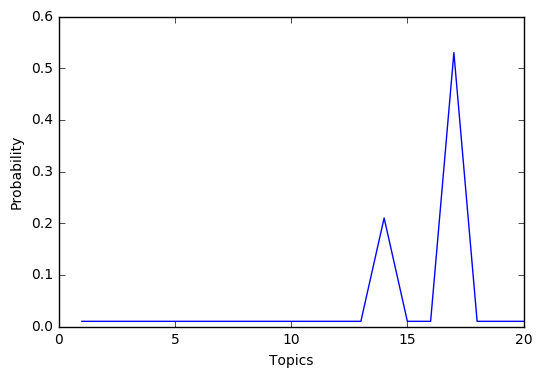

In [20]:
# visualise probability topic distribution of single document

import pandas as pd
import matplotlib.pyplot as plt


plt.plot(range(1,21), df_document_topic.iloc[8][0:20].values) 
# naming the x axis 
plt.xlabel('Topics') 
# naming the y axis 
plt.ylabel('Probability') 

plt.show()

### WordCloud representation of the topic 1
#### This wordcloud representation depicts topic is combination of selenium and Django

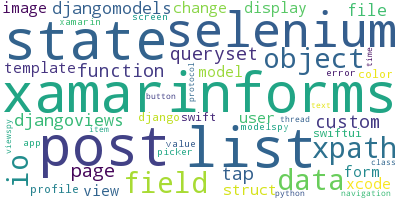

In [30]:
# Topic:3

# Import the wordcloud library
from wordcloud import WordCloud
long_string = ' ,'.join(topTermsInTopic[1:2][0])
wordcloud = WordCloud(background_color="white", max_words=5000)
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### WordCloud representation of the topic 3
#### This wordcloud representation depicts topic is panda dataframe

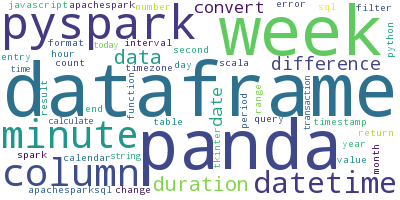

In [28]:
# Topic:3

# Import the wordcloud library
from wordcloud import WordCloud
long_string = ' ,'.join(topTermsInTopic[2:3][0])
wordcloud = WordCloud(background_color="white", max_words=5000)
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### WordCloud representation of the topic 5
#### This wordcloud representation depicts topic is SQL

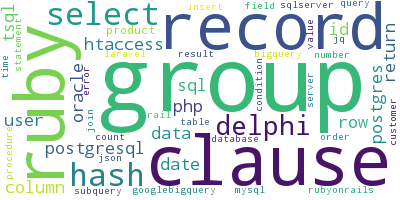

In [32]:
# Topic:4 

# Import the wordcloud library
from wordcloud import WordCloud
long_string = ' ,'.join(topTermsInTopic[4:5][0])
wordcloud = WordCloud(background_color="white", max_words=5000)
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### This wordcloud representation depicts topic is Git

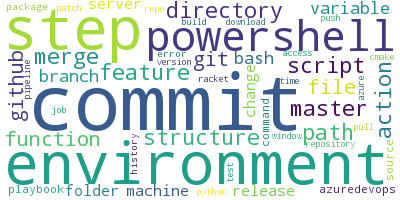

In [64]:
# Topic:10

# Import the wordcloud library
from wordcloud import WordCloud
long_string = ' ,'.join(topTermsInTopic[10:11][0])
wordcloud = WordCloud(background_color="white", max_words=5000)
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### visualise the test data in cluster of topic 5


In [44]:
test_ans[test_ans["PredictedTopic"]==20]

,Tags,CreationDate,AnswerOwnerUserId,AnswerCreationDate,AnswerScore,PredictedTopic,RecommendedAnswerer,TagSim,UserSim
41,html css,2020-01-02 00:41:32,949217,2020-01-02 01:11:37,2,20,"7495930,1526406,3244064,97337,2978923,4148902,...",0.500000,0
48,css reactjs,2020-01-02 05:10:33,6544460,2020-01-02 05:21:55,1,20,"7495930,1526406,3244064,4148902,2978923,97337,...",0.500000,0
59,html css,2020-01-01 16:20:09,12627995,2020-01-01 17:15:13,0,20,"7495930,1526406,3244064,97337,4148902,2978923,...",0.500000,0
78,javascript,2020-01-01 18:20:46,3290797,2020-01-01 21:17:46,1,20,"7495930,1526406,3244064,97337,4148902,2978923,...",1.000000,0
96,bootstrap-4,2020-01-02 03:32:58,368697,2020-01-02 03:37:59,1,20,"7495930,1526406,3244064,4148902,2978923,97337,...",0.000000,0
122,javascript jquery html css,2020-01-02 11:22:56,1578983,2020-01-02 11:30:59,2,20,"7495930,1526406,3244064,2978923,4148902,97337,...",0.750000,0
173,html css,2020-01-02 19:41:36,2175365,2020-01-02 20:02:10,0,20,"7495930,1526406,3244064,2978923,97337,4148902,...",0.500000,0
179,vue.js vuetify.js,2020-01-02 11:06:26,5690940,2020-01-03 12:59:09,1,20,"7495930,1526406,3244064,2978923,4148902,97337,...",0.000000,0
277,php html css,2020-01-03 06:56:58,8034754,2020-01-03 07:15:37,0,20,"7495930,1526406,3244064,2978923,97337,4148902,...",0.333333,0
347,javascript html css,2020-01-05 14:08:31,1183252,2020-01-05 14:22:33,1,20,"7495930,1526406,3244064,2978923,4148902,97337,...",0.666667,0


#### check the skills of recommended users of one of the test set question  by retriving the previous answers given in traning data set

In [55]:

# 7495930,1526406,3244064,2978923,4148902,97337
train_ans[train_ans["AnswerOwnerUserId"]==1526406]

,Tags,CreationDate,AnswerOwnerUserId,AnswerCreationDate,AnswerScore,Topic
14211,javascript reactjs,2020-04-08 04:59:57,1526406,2020-04-08 05:14:04,1,20
21203,javascript reactjs,2020-05-21 06:57:59,1526406,2020-05-21 07:52:45,2,19
44528,javascript html reactjs,2020-01-04 07:16:59,1526406,2020-01-04 08:22:17,2,17
46065,javascript reactjs next.js,2020-01-23 23:32:24,1526406,2020-01-25 01:36:36,14,20
